### Database Creation

In [1]:
# Importing necessary libraries for database creation

import json                             # For handling JSON data if needed
from sqlalchemy import create_engine    # For database connectivity and operations
import dask.dataframe as dd             # For working with large datasets efficiently using Dask
import os                               # For interacting with the operating system environment

In [2]:
# Define the file path

business_file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'
checkin_file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json'
review_file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'
tip_file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json'
user_file_path = '/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json'

In [3]:
# Define file paths
file_paths = [business_file_path, checkin_file_path, review_file_path, tip_file_path, user_file_path]

# Print file sizes in the specified format
for path in file_paths:
    if os.path.exists(path):
        file_name = os.path.basename(path)
        file_size = os.path.getsize(path) / (1024 * 1024)
        print(f"File Size of {file_name}: {file_size:.2f} MiB")

File Size of yelp_academic_dataset_business.json: 113.36 MiB
File Size of yelp_academic_dataset_checkin.json: 273.67 MiB
File Size of yelp_academic_dataset_review.json: 5094.40 MiB
File Size of yelp_academic_dataset_tip.json: 172.24 MiB
File Size of yelp_academic_dataset_user.json: 3207.52 MiB


In [4]:
# Read Business JSON file into a Dask DataFrame
business_df = dd.read_json(business_file_path, lines=True, blocksize='11 MiB')

# Read Checkin JSON file into a Dask DataFrame
checkin_df = dd.read_json(checkin_file_path, lines=True, blocksize='27 MiB')

# Read Review JSON file into a Dask DataFrame
review_df = dd.read_json(review_file_path, lines=True, blocksize='250 MiB')

# Read Tip JSON file into a Dask DataFrame
tip_df = dd.read_json(tip_file_path, lines=True, blocksize='17 MiB')

# Read User JSON file into a Dask DataFrame
user_df = dd.read_json(user_file_path, lines=True, blocksize='160 MiB')

In [5]:
# In above cell data divided into equal blocks based on the file size. 

print(business_df.npartitions)
print(checkin_df.npartitions)
print(review_df.npartitions)
print(tip_df.npartitions)
print(user_df.npartitions)

10
10
20
10
20


In [8]:
%%time 
# %%time:- Measure and display the execution time of the below code            

# Compute the concatenated dataframe
business_df = business_df.compute()
checkin_df = checkin_df.compute()
review_df = review_df.compute()
tip_df = tip_df.compute()
user_df = user_df.compute()

CPU times: user 4min 20s, sys: 2min 39s, total: 7min
Wall time: 6min 54s


In [10]:
# Checking the dimensions (shape) of the dataframes

print(business_df.shape)
print(checkin_df.shape)
print(review_df.shape)
print(tip_df.shape)
print(user_df.shape)

(150346, 14)
(131930, 2)
(6990280, 9)
(908915, 5)
(1987897, 22)


In [11]:
# Removing 'attributes' & 'hours' table from  business_df dataframe as per the business problem statements. No need of these two columns.
business_df.drop(['attributes', 'hours'], axis=1, inplace=True)

In [12]:
#Establishing a SQLite database engine named 'yelp.db'
engine = create_engine('sqlite:///yelp.db')

In [13]:
# Function to load a Pandas DataFrame into an SQLite database table using the provided engine.
def load_dataframe(df, table_name, engine):
  df.to_sql(table_name, con=engine, if_exists='replace', index=True)

In [14]:
%%time
#Load each DataFrame into a separate table
load_dataframe(business_df, 'business', engine)
load_dataframe(checkin_df, 'checkin', engine)
load_dataframe(review_df, 'review', engine)
load_dataframe(tip_df, 'tip', engine)
load_dataframe(user_df, 'user', engine)

CPU times: user 5min 14s, sys: 46.8 s, total: 6min 1s
Wall time: 6min 16s


### Problem Statement

In a competitive market like restaurant industry, understading the factors that influence business success is crucial for stakeholders. Utilizing the Yelp dataset, this project aims to investigate the relationship between user engagement(reviews, tips and check-ins) and business success metrics (review count, ratings) for restaurants.

### Research Objectives

> Quantify the correlation between user engagement (reviews, tips, check_ins) and review count/average star rating:
This will help us determine if restaurants with higher user engagements experience a corresponding increase reviews and ratings

> Analyze the impact of sentiment on review count and average star rating: We will investigate if positive sentiment in reviews and tips translates to higher star ratings and potentially the total number of reviews left.

> Time trends in User Enagament: We will explore if consistent user engagement over time is a stronger indicator of long-term success compared to sporadic burst of activity

### Hypothesis Testing

> Higher levels of user engagement (more reviews, tips and check-ins) correlate with higher reveiw counts and ratings for restaurants.
> Positive sentiment expressed in reviews and tips contributes to higher overall ratings and reviews counts for restaurants.
> Consistent engagement over time is positively associated with sustained business success for restaurants.


### Importing Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import sqlite3
import folium
from geopy.geocoders import Nominatim
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Database Connection

In [16]:
#Creating database connection
conn = sqlite3.connect('yelp.db')

In [17]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table'", conn)

In [18]:
tables

,name
0,business
1,checkin
2,review
3,tip
4,user


In [19]:
#Explore what type of data available in the tables
for table in tables['name']:
    display(pd.read_sql_query(f"select * from {table} limit 5", conn))

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food"


,index,business_id,date
0,0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11.000000
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18.000000
2,2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30.000000
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03.000000
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15.000000


,index,user_id,business_id,text,date,compliment_count
0,0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21.000000,0
1,1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10.000000,0
2,2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08.000000,0
3,3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38.000000,0
4,4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09.000000,0


,index,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",...,65,55,56,18,232,844,467,467,239,180
1,1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",...,13,10,17,3,66,96,119,119,35,18
3,3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",...,4,1,6,2,12,16,26,26,10,9
4,4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",...,1,0,0,0,1,1,0,0,0,0


### Data Analysis

In [20]:
#Total Number of Businesses (Unique)
pd.read_sql_query("select count(*) from business", conn)

,count(*)
0,150346


In [21]:
# Restaurant business with open status 
res_business_id = pd.read_sql_query("select business_id, review_count from business where lower(categories) like '%restaurant%' and is_open = 1", conn)
res_business_id

,business_id,review_count
0,MTSW4McQd7CbVtyjqoe9mw,80
1,CF33F8-E6oudUQ46HnavjQ,6
2,bBDDEgkFA1Otx9Lfe7BZUQ,10
3,eEOYSgkmpB90uNA7lDOMRA,10
4,il_Ro8jwPlHresjw9EGmBg,28
...,...,...
34999,w_4xUt-1AyY2ZwKtnjW0Xg,998
35000,l9eLGG9ZKpLJzboZq-9LRQ,11
35001,cM6V90ExQD6KMSU3rRB5ZA,33
35002,WnT9NIzQgLlILjPT0kEcsQ,35


There are a total of 35,004 businesses in the restaurant category that have an open status.

In [22]:
#What is the descriptive stats for review count and star rating for business?
#avg, min, max, median

pd.read_sql_query(f"""
SELECT
    AVG(review_count) AS avg_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (
        SELECT review_count
        FROM business
        ORDER BY review_count
        LIMIT 1
        OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_review_count,
    
    AVG(stars) AS avg_star_count,
    MIN(stars) AS min_star_count,
    MAX(stars) AS max_star_count,
    (
        SELECT stars
        FROM business
        ORDER BY stars
        LIMIT 1
        OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_star_count
    
    
FROM business
WHERE business_id IN {tuple(res_business_id['business_id'])}""", conn).transpose()


,0
avg_review_count,104.097789
min_review_count,5.000000
max_review_count,7568.000000
median_review_count,15.000000
avg_star_count,3.523969
min_star_count,1.000000
max_star_count,5.000000
median_star_count,3.500000


Based on the above values, with a maximum review count of 7568 and a median review count of 15, it is evident that there are outliers present in our business table.




In [23]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)   # Calculate the 1st quartile (25th percentile) of the column
    q3 = df[col].quantile(0.75)   # Calculate the 3rd quartile (75th percentile) of the column
    iqr = q3 - q1                # Calculate the Interquartile Range (IQR) of the column
    lower_bound = q1 - 1.5 * iqr  # Calculate the lower bound for outliers using IQR method
    upper_bound = q3 + 1.5 * iqr  # Calculate the upper bound for outliers using IQR method
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  # Filter dataframe rows within the bounds
    return df  # Return the filtered dataframe without outliers


In [24]:
business_id  = remove_outliers(res_business_id, 'review_count')

In [25]:
business_id.shape

(31537, 2)

In [26]:
# As we removed outliers with remove_outliers function so we're rechecking review count to confirm it. 

pd.read_sql_query(f"""
SELECT
    AVG(review_count) AS avg_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (
        SELECT review_count
        FROM business
        ORDER BY review_count
        LIMIT 1
        OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_review_count,
    
    AVG(stars) AS avg_star_count,
    MIN(stars) AS min_star_count,
    MAX(stars) AS max_star_count,
    (
        SELECT stars
        FROM business
        ORDER BY stars
        LIMIT 1
        OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_star_count
    
    
FROM business
WHERE business_id IN {tuple(business_id['business_id'])}""", conn).transpose()

,0
avg_review_count,55.975426
min_review_count,5.000000
max_review_count,248.000000
median_review_count,15.000000
avg_star_count,3.477281
min_star_count,1.000000
max_star_count,5.000000
median_star_count,3.500000


Now we can see that maximum review count is 248 and a median review count is 15, it is evident that there are outliers are not present in our business dataset. as we applied remove_outliers function in review_count column in business dataframe.

In [27]:
# Which restaurants have the highest number of reviews?

pd.read_sql_query(f"""select name, sum(review_count) as review_count, avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by review_count desc limit 10
""", conn)

,name,review_count,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7687,3.377419
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5744,2.514706


The output analysis reveals that despite higher review counts, restaurants do not consistently exhibit higher average ratings. This suggests that there isn't a strict correlation between review count and rating, challenging the assumption that higher review counts always lead to higher ratings.

In [28]:
# Which restaurants have the highest ratings?

pd.read_sql_query(f"""select name, sum(review_count) as review_count, avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by avg_rating desc limit 10
""", conn)

,name,review_count,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


The results show that restaurants with better average ratings don't always get more reviews. This means that the link between rating and review count isn't clear-cut, questioning the idea that higher ratings automatically lead to more reviews.

In [29]:
# Do restaurants with higher engagement tend to have higher ratings?


pd.read_sql_query("""
select business_id,
sum(length(date) - length(replace(date,',',''))+1) as checkin_count
from checkin
group by business_id
""", conn)

,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


In [30]:
#Total tip count for each businesses.
pd.read_sql_query("""
select business_id, count(*) as tip_count
from tip
group by business_id
""", conn)

,business_id,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,4
1,--0iUa4sNDFiZFrAdIWhZQ,6
2,--30_8IhuyMHbSOcNWd6DQ,1
3,--7PUidqRWpRSpXebiyxTg,3
4,--8IbOsAAxjKRoYsBFL-PA,4
...,...,...
106188,zzjCxn89a7RQo8keIOO_Ag,1
106189,zzjFdJwXuxBOGe9JeY_EMw,2
106190,zznJox6-nmXlGYNWgTDwQQ,6
106191,zzu6_r3DxBJuXcjnOYVdTw,2


In [31]:
#Total tip count for each businesses. [order by tip count]
pd.read_sql_query(f"""select business_id, count(business_id) as tip_count from tip group by business_id order by tip_count""", conn)

,business_id,tip_count
0,--30_8IhuyMHbSOcNWd6DQ,1
1,--9osgUCSDUWUkoTLdvYhQ,1
2,--FWWsIwxRwuw9vIMImcQg,1
3,--ZWv8kGlM2YL58uKhGJDg,1
4,--_9CAxgfXZmoFdNIRrhHA,1
...,...,...
106188,Eb1XmmLWyt_way5NNZ7-Pw,826
106189,ytynqOUb3hjKeJfRj5Tshw,827
106190,_ab50qdWOk0DdB6XOrBitw,932
106191,-QI8Qi8XWH3D8y8ethnajA,1011


In [32]:
# Average count for review, checking, tip with respect to the average rating
review_count_df = pd.read_sql_query(f"""
select total.avg_rating as rating,
avg(total.review_count) as avg_review_count,
avg(total.checkin_count) as avg_checkin_count,
avg(total.tip_count) as avg_tip_count
from (select
      b.business_id,
      sum(b.review_count) as review_count,
      avg(b.stars) as avg_rating,
      sum(length(cc.date) - length(replace(cc.date, ',', '')) +1) as checkin_count,
      sum(tip.tip_count) as tip_count
      from business b
      left join checkin cc
      on b.business_id = cc.business_id
      left join (select business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip 
      on b.business_id = tip.business_id
      where b.business_id in {tuple(business_id['business_id'])}
      group by b.business_id) as total
group by rating""",conn)

review_count_df

,rating,avg_review_count,avg_checkin_count,avg_tip_count
0,1.0,14.365079,17.518072,2.781513
1,1.5,24.358459,34.480969,3.884654
2,2.0,27.759629,52.386515,4.581058
3,2.5,36.631037,79.349429,6.325225
4,3.0,48.054998,105.970405,8.301950
5,3.5,63.730125,125.781702,10.320786
6,4.0,73.136954,127.139075,11.329362
7,4.5,65.282554,86.177605,8.995201
8,5.0,31.127979,27.545113,4.269082


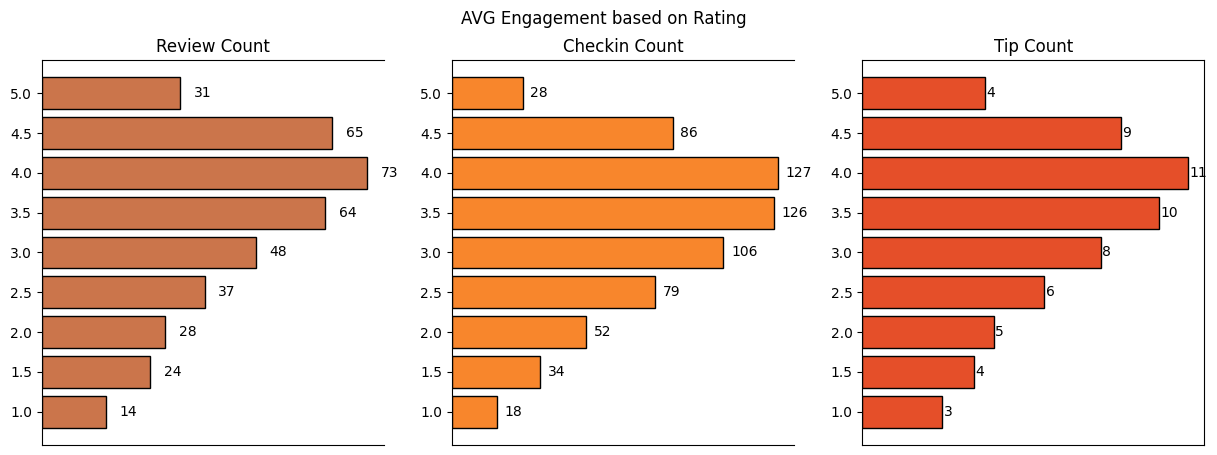

In [33]:
plt.figure(figsize=(15,5))
plt.suptitle('AVG Engagement based on Rating\n\n')
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,1)
plt.title('Review Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_review_count'], edgecolor = 'k', color = '#CB754B')
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_review_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')
    
plt.xticks([])
plt.subplot(1,3,2)
plt.title('Checkin Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_checkin_count'], edgecolor = 'k', color = '#F8862C')
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_checkin_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')
    
plt.xticks([])
plt.subplot(1,3,3)
plt.title('Tip Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_tip_count'], edgecolor = 'k', color='#E54F29')
for i, value in enumerate(review_count_df['avg_tip_count']):
    plt.text(value+0.05, i, str(round(value)), color='black', va='center')
plt.xticks([])
plt.show()

In [34]:
#Is there a correlation between the number of reviews, tips, and check-ins for a business?

engagement_df = pd.read_sql_query(f"""select
      b.business_id,
      sum(b.review_count) as review_count,
      avg(b.stars) as avg_rating,
      sum(length(cc.date) - length(replace(cc.date, ',', '')) +1) as checkin_count,
      sum(tip.tip_count) as tip_count
      from business b
      left join checkin cc
      on b.business_id = cc.business_id
      left join (select business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip 
      on b.business_id = tip.business_id
      where b.business_id in {tuple(business_id['business_id'])}
      group by b.business_id""",conn).dropna()

engagement_df

,business_id,review_count,avg_rating,checkin_count,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,24,4.5,11.0,4.0
1,--0iUa4sNDFiZFrAdIWhZQ,14,3.0,10.0,6.0
2,--epgcb7xHGuJ-4PUeSLAw,34,3.0,118.0,6.0
4,--lqIzK-ZVTtgwiQM63XgQ,15,2.0,21.0,2.0
5,-09Oc2D14vRnmirPh0vlXw,135,3.0,500.0,25.0
...,...,...,...,...,...
31530,zzIF9qp2UoHN48EeZH_IDg,19,3.0,6.0,5.0
31532,zzbZtgPYZS8sTIWQH6DwEw,86,3.0,292.0,17.0
31533,zziDpuuJw-Km1J4BaGpBKA,6,3.5,20.0,2.0
31534,zzjFdJwXuxBOGe9JeY_EMw,47,4.0,27.0,2.0


In [35]:
# Correlation matrix for the 'review_count', 'checkin_count', and 'tip_count' columns in the engagement_df DataFrame
# This helps to understand the linear relationships between these variables.
engagement_df[['review_count', 'checkin_count', 'tip_count']].corr()

,review_count,checkin_count,tip_count
review_count,1.000000,0.626884,0.766321
checkin_count,0.626884,1.000000,0.772088
tip_count,0.766321,0.772088,1.000000


<Axes: >

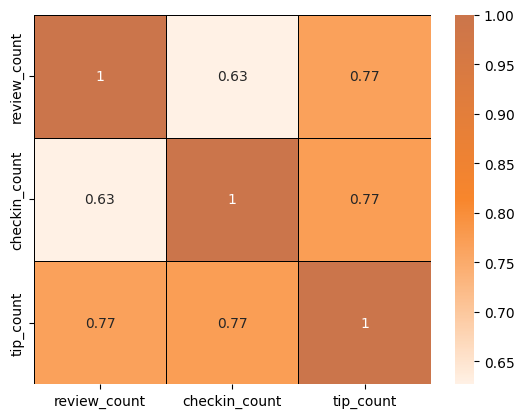

In [36]:
colors = ['#FFF1E5', '#F8862C', '#CB754B']
custom_cmap = LinearSegmentedColormap.from_list("mycmap", colors)
sns.heatmap(engagement_df[['review_count', 'checkin_count', 'tip_count']].corr(), cmap = custom_cmap, annot = True, linewidth = 0.5, linecolor='black')

In [37]:
#Is there a difference in the user engagement (reviews, tips, and check-ins) between high_rated and low-rated business?

engagement_df = pd.read_sql_query(f"""select
      b.business_id,
      sum(b.review_count) as review_count,
      avg(b.stars) as avg_rating,
      sum(length(cc.date) - length(replace(cc.date, ',', '')) +1) as checkin_count,
      sum(tip.tip_count) as tip_count,
      (case when b.stars >= 3.5 then 'High-Rated' else 'Low_Rated' end) as category
from 
    business b
left join 
    checkin cc
    on b.business_id = cc.business_id
left join
    (select business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip 
    on b.business_id = tip.business_id
where b.business_id in {tuple(business_id['business_id'])}
group by
    b.business_id
    
""",conn).dropna()

engagement_df

,business_id,review_count,avg_rating,checkin_count,tip_count,category
0,---kPU91CF4Lq2-WlRu9Lw,24,4.5,11.0,4.0,High-Rated
1,--0iUa4sNDFiZFrAdIWhZQ,14,3.0,10.0,6.0,Low_Rated
2,--epgcb7xHGuJ-4PUeSLAw,34,3.0,118.0,6.0,Low_Rated
4,--lqIzK-ZVTtgwiQM63XgQ,15,2.0,21.0,2.0,Low_Rated
5,-09Oc2D14vRnmirPh0vlXw,135,3.0,500.0,25.0,Low_Rated
...,...,...,...,...,...,...
31530,zzIF9qp2UoHN48EeZH_IDg,19,3.0,6.0,5.0,Low_Rated
31532,zzbZtgPYZS8sTIWQH6DwEw,86,3.0,292.0,17.0,Low_Rated
31533,zziDpuuJw-Km1J4BaGpBKA,6,3.5,20.0,2.0,High-Rated
31534,zzjFdJwXuxBOGe9JeY_EMw,47,4.0,27.0,2.0,High-Rated


In [38]:
engagement_df.groupby("category")[['review_count', 'tip_count', 'checkin_count']].mean()

,review_count,tip_count,checkin_count
category,,,
High-Rated,72.291062,10.162766,122.066641
Low_Rated,42.123420,6.541689,88.880828


In [39]:
# function to calculate the success score based on the avg rating and total review count

def calculate_success_metric(df):
    success_score = []
    for index, row in df.iterrows():
        score = row['avg_rating'] * np.log(row['review_count'] + 1)
        success_score.append(score)
    return success_score

In [40]:
#How do the success metrics (review_count or avg_rating) of restaurants vary across different states and cities?
city_df = pd.read_sql_query(f"""
select city, state, latitude, longitude, avg(stars) as avg_rating, sum(review_count) as review_count, count(*) as restaurant_count
from business
where business_id in {tuple(business_id['business_id'])}
group by state, city
order by review_count desc
limit 10

""", conn)

city_df['success_score'] = calculate_success_metric(city_df)

In [41]:
city_df

,city,state,latitude,longitude,avg_rating,review_count,restaurant_count,success_score
0,Philadelphia,PA,39.955505,-75.155564,3.532156,175487,3001,42.651934
1,Tampa,FL,27.890814,-82.502346,3.571429,104376,1715,41.270588
2,Indianapolis,IN,39.637133,-86.127217,3.412111,92639,1701,39.022521
3,Tucson,AZ,32.338572,-111.010760,3.386187,91613,1419,38.688341
4,Nashville,TN,36.208102,-86.768170,3.493590,87070,1404,39.737764
5,New Orleans,LA,29.963974,-90.042604,3.693676,69239,1012,41.167252
6,Saint Louis,MO,38.583223,-90.407187,3.414303,51490,811,37.042331
7,Reno,NV,39.476518,-119.784037,3.479626,48393,589,37.535187
8,Edmonton,AB,53.436403,-113.604288,3.509379,45916,1546,37.671748
9,Boise,ID,43.611192,-116.206275,3.558824,36104,561,37.346958


In [42]:
#Create a base map
m = folium.Map(location = [city_df['latitude'].mean(), city_df['longitude'].mean()], zoom_start=4)

#Define a color scale
color_scale = folium.LinearColormap(colors=['green', 'yellow', '#E54F29'],
                                    vmin=city_df['success_score'].min(),
                                    vmax=city_df['success_score'].max())

# Add markers to the map
for index, row in city_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_scale(row['success_score']),
        fill=True,
        fill_color=color_scale(row['success_score']),
        fill_opacity=0.7,
        popup=f"Success Score: {row['success_score']}"
    ).add_to(m)
    
# Add color scale to the map
m.add_child(color_scale)

In [43]:
# Are there any patterns in user engagement over time for successful businesses compared to less successful ones?
# Are there any seasonal trends in the user engagement for restaurants?

high_rated_engagement = pd.read_sql_query(f"""
select review.month_year, review.review_count, tip.tip_count
from
(select strftime('%m-%Y', date) as month_year, count(*) as review_count
from review
where business_id in {tuple(business_id['business_id'])} and stars >= 3.5
group by month_year
order by month_year) as review
join
(select avg(b.stars), strftime('%m-%Y', tip.date) as month_year, count(*) as tip_count
from tip
join business b
on tip.business_id = b.business_id
where tip.business_id in {tuple(business_id['business_id'])} and b.stars >= 3.5
group by month_year
order by month_year) as tip

on review.month_year = tip.month_year
""", conn)

low_rated_engagement = pd.read_sql_query(f"""
select review.month_year, review.review_count, tip.tip_count
from
(select strftime('%m-%Y', date) as month_year, count(*) as review_count
from review
where business_id in {tuple(business_id['business_id'])} and stars < 3.5
group by month_year
order by month_year) as review
join
(select avg(b.stars), strftime('%m-%Y', tip.date) as month_year, count(*) as tip_count
from tip
join business b
on tip.business_id = b.business_id
where tip.business_id in {tuple(business_id['business_id'])} and b.stars < 3.5
group by month_year
order by month_year) as tip

on review.month_year = tip.month_year
""", conn)

In [44]:
high_rated_engagement

,month_year,review_count,tip_count
0,01-2010,1218,79
1,01-2011,2171,621
2,01-2012,3086,1321
3,01-2013,3801,1230
4,01-2014,4973,1357
...,...,...,...
149,12-2017,10161,1477
150,12-2018,12870,1163
151,12-2019,13756,1161
152,12-2020,11294,937


In [45]:
low_rated_engagement

,month_year,review_count,tip_count
0,01-2010,613,25
1,01-2011,1103,297
2,01-2012,1748,538
3,01-2013,2196,548
4,01-2014,2769,607
...,...,...,...
149,12-2017,5970,441
150,12-2018,7574,338
151,12-2019,7591,275
152,12-2020,5014,148


In [46]:
time_rating = pd.read_sql_query(f"""
select strftime('%m-%Y', date) as month_year, avg(stars) as avg_rating 
from review
where business_id in {tuple(business_id['business_id'])}
group by month_year
order by month_year;
""", conn)

In [47]:
time_rating

,month_year,avg_rating
0,01-2006,4.000000
1,01-2007,3.897436
2,01-2008,3.603960
3,01-2009,3.690661
4,01-2010,3.724194
...,...,...
198,12-2017,3.613415
199,12-2018,3.608687
200,12-2019,3.665246
201,12-2020,3.833701


In [48]:
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace = True)
time_rating = time_rating[time_rating['month_year']>'2017']

high_rated_engagement['month_year'] = pd.to_datetime(high_rated_engagement['month_year'])
high_rated_engagement.sort_values('month_year', inplace=True)
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year']>'2017']

low_rated_engagement['month_year'] = pd.to_datetime(low_rated_engagement['month_year'])
low_rated_engagement.sort_values('month_year', inplace=True)
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year']>'2017']

In [49]:
high_rated_engagement['avg_rating'] = time_rating['avg_rating'].values

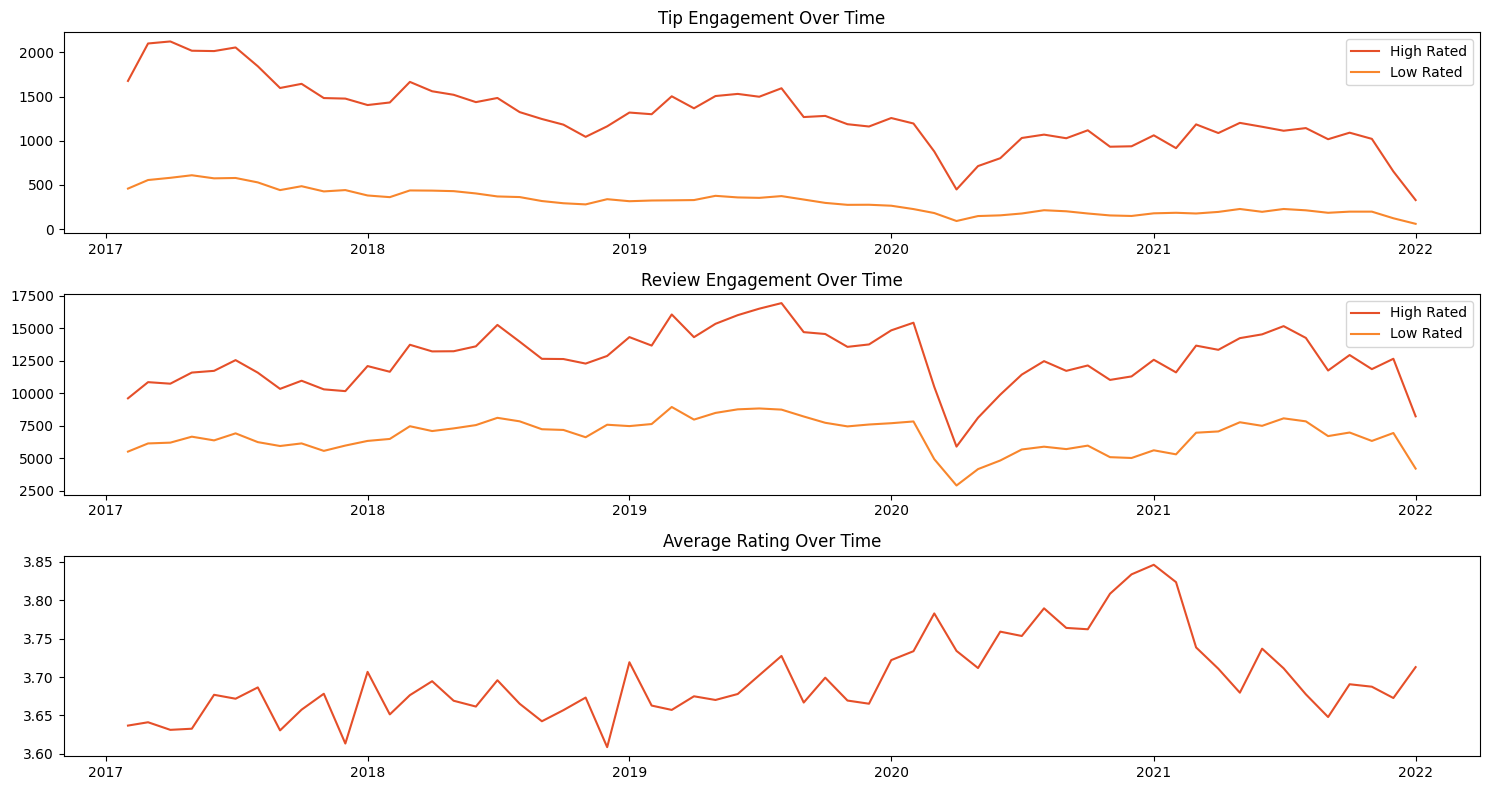

In [50]:
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.title('Tip Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label = 'High Rated', color = '#E54f29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['tip_count'], label = 'Low Rated', color = '#F8862C')
plt.legend()
plt.subplot(3, 1, 2)
plt.title("Review Engagement Over Time")
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['review_count'], label = 'High Rated', color = '#E54f29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['review_count'], label = 'Low Rated', color = '#F8862C')
plt.legend()
plt.subplot(3, 1, 3)
plt.title("Average Rating Over Time")
plt.plot(time_rating['month_year'], time_rating['avg_rating'], color = '#E54F29')
plt.tight_layout()
plt.show()

In [51]:
tip_high_rated = high_rated_engagement[['month_year', 'tip_count']].set_index('month_year')
review_high_rated = high_rated_engagement[['month_year', 'review_count']].set_index('month_year')
rating_df = time_rating[['month_year', 'avg_rating']].set_index('month_year')

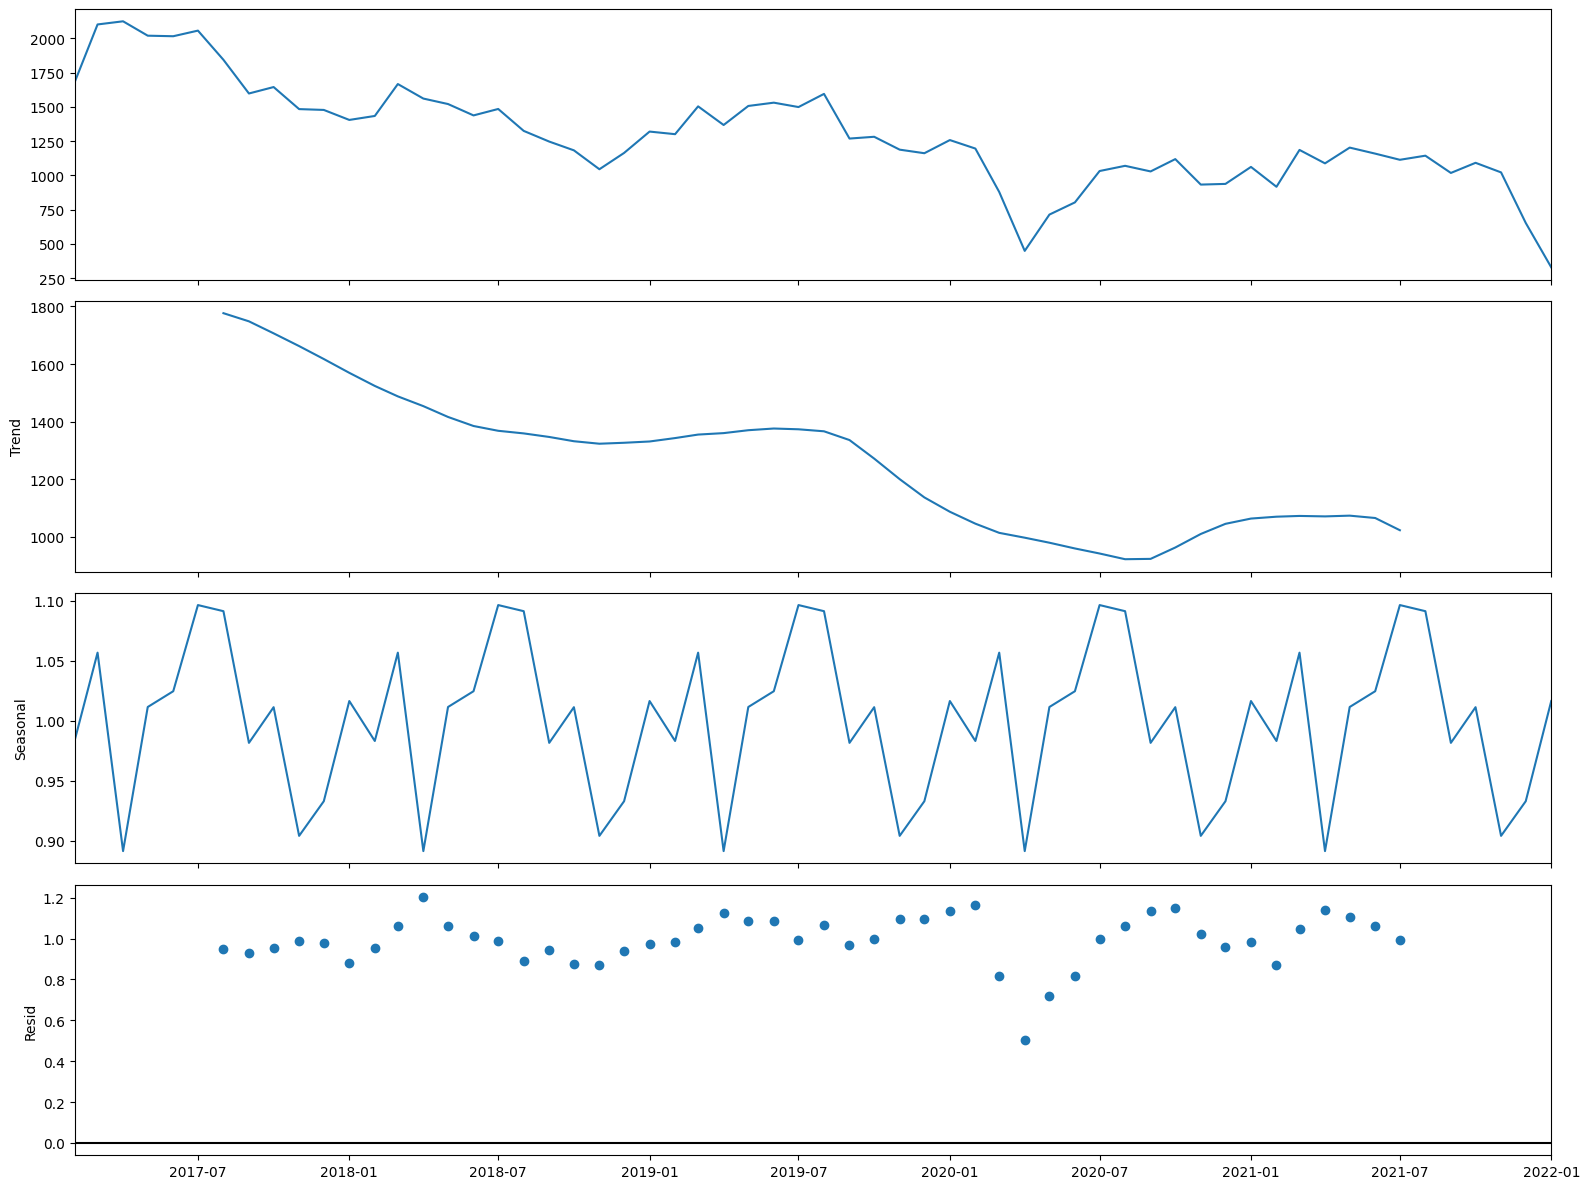

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(tip_high_rated, model='multiplicative', period=12)

plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot()
plt.show()

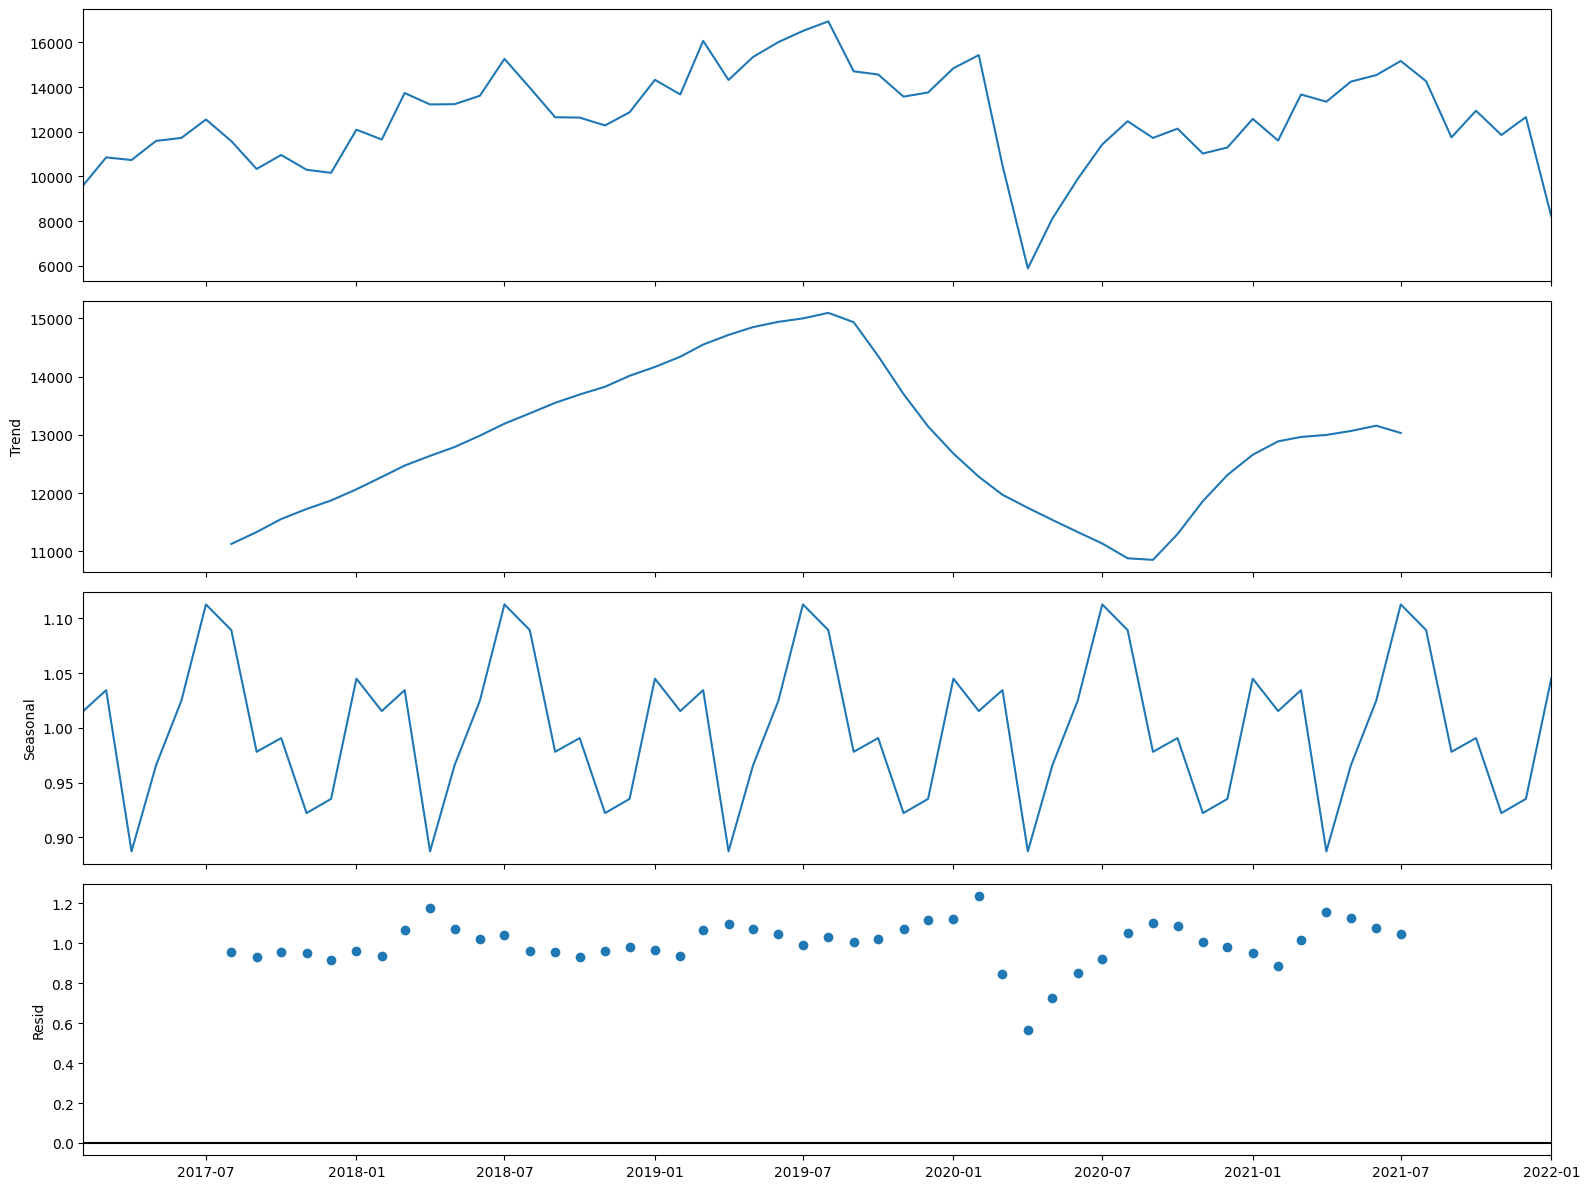

In [53]:
multiplicative_decomposition = seasonal_decompose(review_high_rated, model='multiplicative', period=12)

plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot()
plt.show()

In [54]:
#How does the sentiment of reviews and tips (useful, funny, cool) correlate with the success metrics of restaurants?

sentiment_df = pd.read_sql_query(f"""select b.business_id, avg(b.stars) as avg_rating, sum(b.review_count) as review_count,
sum(s.useful_count) as useful_count,
sum(s.funny_count) as funny_count,
sum(s.cool_count) as cool_count
from
(select business_id,
    sum(useful) as useful_count,
    sum(funny) as funny_count,
    sum(cool) as cool_count
from
    review
group by business_id) as s
join business as b on b.business_id = s.business_id
where b.business_id in {tuple(business_id['business_id'])}
group by b.business_id
order by review_count""", conn)

sentiment_df = remove_outliers(sentiment_df, 'review_count')
sentiment_df = remove_outliers(sentiment_df, 'useful_count')
sentiment_df = remove_outliers(sentiment_df, 'funny_count')
sentiment_df = remove_outliers(sentiment_df, 'cool_count')

In [55]:
sentiment_df

,business_id,avg_rating,review_count,useful_count,funny_count,cool_count
0,-2CPhK6ik9ZBgFX_F-dkxQ,2.0,5,3,5,3
1,-3ArWZfDjfab8qVHf3WVtg,4.0,5,18,3,2
2,-4lNMmoW7gRxkH0c2dfXfA,4.0,5,1,0,0
3,-7UDKbg_8TL4LVuYR6Ooyw,3.0,5,3,0,2
4,-AzaeuPwxqFO4SMSKjbuCw,3.0,5,5,0,0
...,...,...,...,...,...,...
29613,I2_0af3Gu4SyAq4Qdz5cFg,3.0,175,122,26,45
29627,radib3GHt_Up9-zhUjM1ew,3.5,175,128,29,21
29633,17AnbEkqAiE66YFTDYFvgw,2.5,176,110,25,25
29652,ZNZcptwIHne1PDcHaMbA-A,4.0,176,81,13,29


In [56]:
sentiment_df['success_score'] = calculate_success_metric(sentiment_df)

In [57]:
sentiment_df

,business_id,avg_rating,review_count,useful_count,funny_count,cool_count,success_score
0,-2CPhK6ik9ZBgFX_F-dkxQ,2.0,5,3,5,3,3.583519
1,-3ArWZfDjfab8qVHf3WVtg,4.0,5,18,3,2,7.167038
2,-4lNMmoW7gRxkH0c2dfXfA,4.0,5,1,0,0,7.167038
3,-7UDKbg_8TL4LVuYR6Ooyw,3.0,5,3,0,2,5.375278
4,-AzaeuPwxqFO4SMSKjbuCw,3.0,5,5,0,0,5.375278
...,...,...,...,...,...,...,...
29613,I2_0af3Gu4SyAq4Qdz5cFg,3.0,175,122,26,45,15.511452
29627,radib3GHt_Up9-zhUjM1ew,3.5,175,128,29,21,18.096694
29633,17AnbEkqAiE66YFTDYFvgw,2.5,176,110,25,25,12.940374
29652,ZNZcptwIHne1PDcHaMbA-A,4.0,176,81,13,29,20.704599


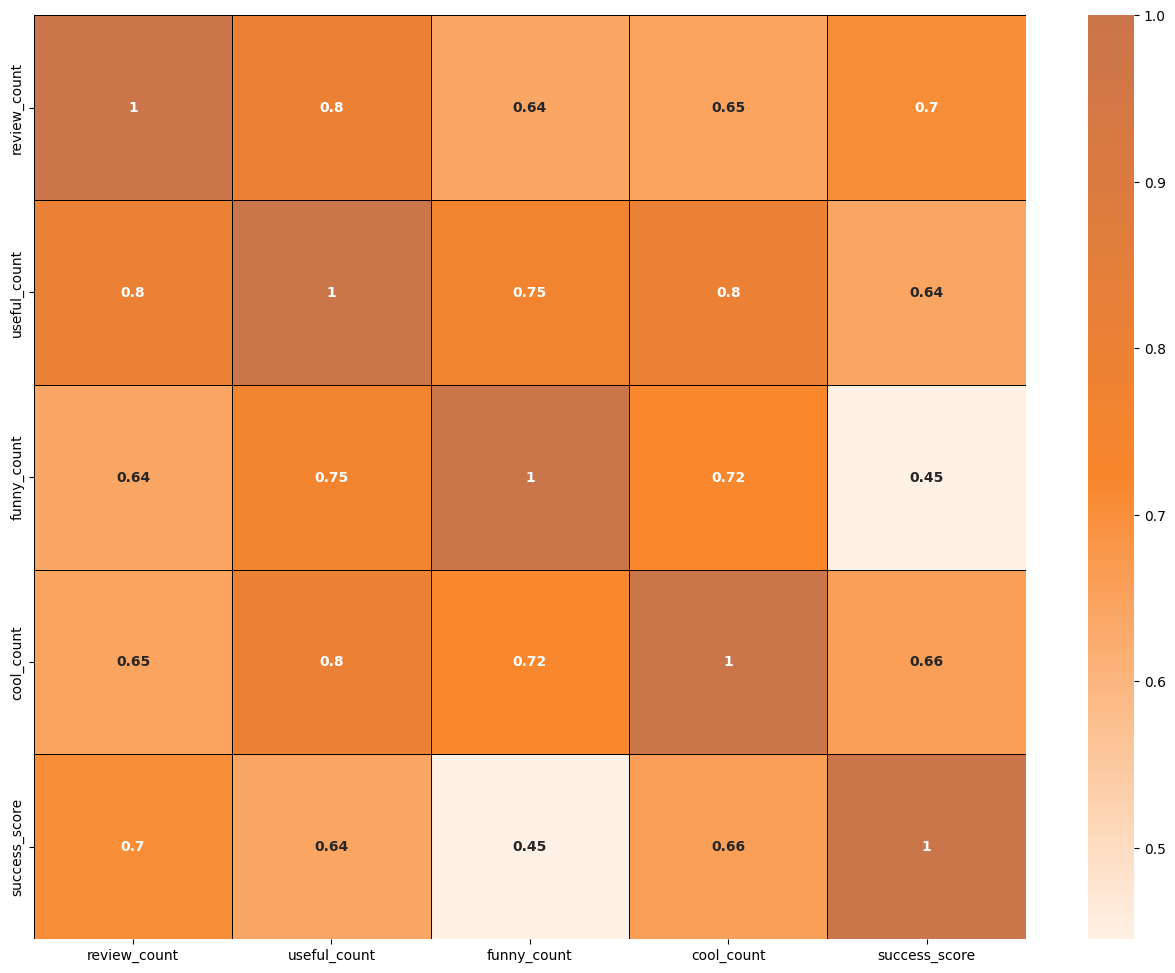

In [59]:
sns.heatmap(sentiment_df.iloc[:,2:].corr(), cmap = custom_cmap, annot = True, linewidths=0.5, linecolor = 'black', annot_kws={'size': 10, 'weight': 'bold'})
plt.show()

In [60]:
#Is there any difference in engagement of elite users and non elite users?

elite_df = pd.read_sql_query("""
select elite, count(*) as num_users, sum(review_count) as total_review_count
from
    (select
        case
            when elite = '' then 'Not Elite'
            else 'Elite'
        end as elite,
        u.review_count
    from
        user u) as user_elite
group by
    elite;
""", conn)

In [61]:
elite_df

,elite,num_users,total_review_count
0,Elite,91198,20484441
1,Not Elite,1896699,26021235


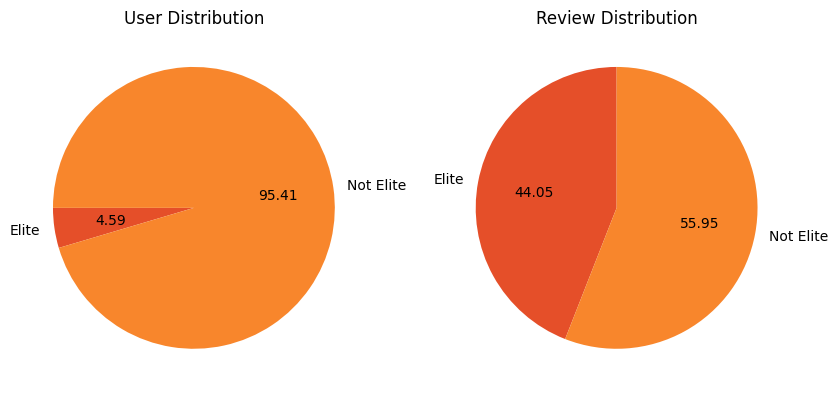

In [62]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('User Distribution')
plt.pie(elite_df['num_users'], labels = elite_df['elite'], autopct='%.2f', startangle=180, colors = ['#E54F29', '#F8862C'])

plt.subplot(1, 2, 2)
plt.title('Review Distribution')
plt.pie(elite_df['total_review_count'], labels = elite_df['elite'], autopct='%.2f', startangle=90, colors = ['#E54F29', '#F8862C'])
plt.show()

In [63]:
# What are the busiest hours for restaurants?

review_engagement = pd.read_sql_query("""
select cast(strftime('%H', date) as integer) as hour, 
count(*) as review_count
from review
group by hour;
""", conn)

tip_engagement = pd.read_sql_query("""
select cast(strftime('%H', date) as integer) as hour, 
count(*) as tip_count
from tip
group by hour;
""", conn)

checkin = pd.read_sql_query("""select date from checkin""", conn)
checkin_engagement = []
for i in checkin['date']:
    checkin_engagement.extend([datetime.strptime(j.strip(), "%Y-%m-%d %H:%M:%S").strftime("%H") for j in i.split(',')])
    
checkin_engagement = pd.DataFrame(checkin_engagement).astype('int').groupby(0)[[0]].count()

In [64]:
checkin_engagement

,0
0,
0,1155092
1,935985
2,669574
3,437035
4,264905
5,152476
6,85066
7,52295
8,35589


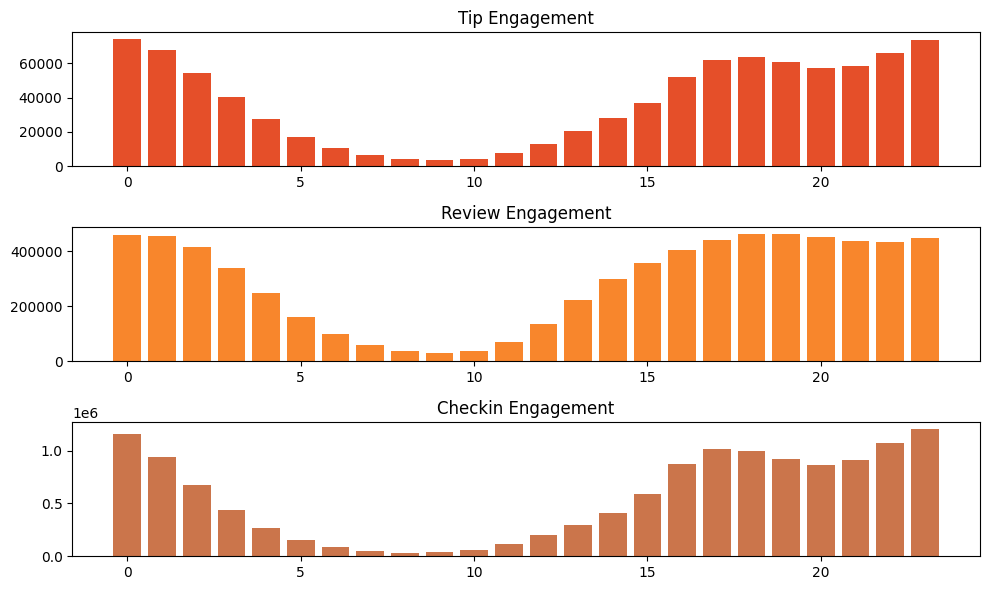

In [65]:
plt.figure(figsize = (10, 6))
plt.subplot(3, 1, 1)
plt.title('Tip Engagement')
plt.bar(tip_engagement['hour'], tip_engagement['tip_count'], color = '#E54f29')
plt.subplot(3, 1, 2)
plt.title('Review Engagement')
plt.bar(review_engagement['hour'], review_engagement['review_count'], color='#F8862C')
plt.subplot(3, 1, 3)
plt.title('Checkin Engagement')
plt.bar(checkin_engagement.index, checkin_engagement[0], color = '#CB754B')
plt.tight_layout()
plt.show()